<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Banking Customer Churn Analysis using AutoML in Vantage
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>

<center><img src="../Banking_Customer_Churn/images/churn.webp"/></center>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Source: <a href = 'https://medium.com/@islamhasabo/predicting-customer-churn-bc76f7760377'>Medium</a></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Customer churn is a critical metric in banking because it can directly impact a bank's revenue and profitability. When customers leave, banks lose the income they would have earned from those customers' transactions, investments, and account fees. Additionally, attracting new customers to replace those who have left can be expensive and time-consuming, so reducing customer churn is often more cost-effective than acquiring new customers.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Customer churn can also be an indicator of customer satisfaction and loyalty. If customers leave at a high rate, they may be dissatisfied with the bank's products or services, customer service, or overall experience.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Banks can use various strategies to reduce customer churns, such as improving customer service, offering more competitive rates and fees, providing personalized recommendations and offers, and enhancing digital channels and mobile apps. By tracking and analyzing customer churn rates, banks can identify areas for improvement and make strategic decisions to retain customers and improve overall customer satisfaction.</p>

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Here, we will use AutoML(Automated Machine Learning) functionality to automate the entire process of developing a predictive model.</li>
    <li>It will perform <code>feature exploration</code>, <code>feature engineering</code>, <code>data preparation</code>, <code>model training</code> and <code>model evaluation</code> on dataset in auto run and at end we will get <code>leaderboard</code> containined different models along with their performance.</li>
    <li>Model will also have <code>rank</code> associated with them which indicates which is `best performing model` for given data followed by other models.</li>
</ul>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>AutoML - Automated Machine Learning</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>AutoML is a comprehensive approach that automates the end-to-end process of applying machine learning to real-world problems.</p>

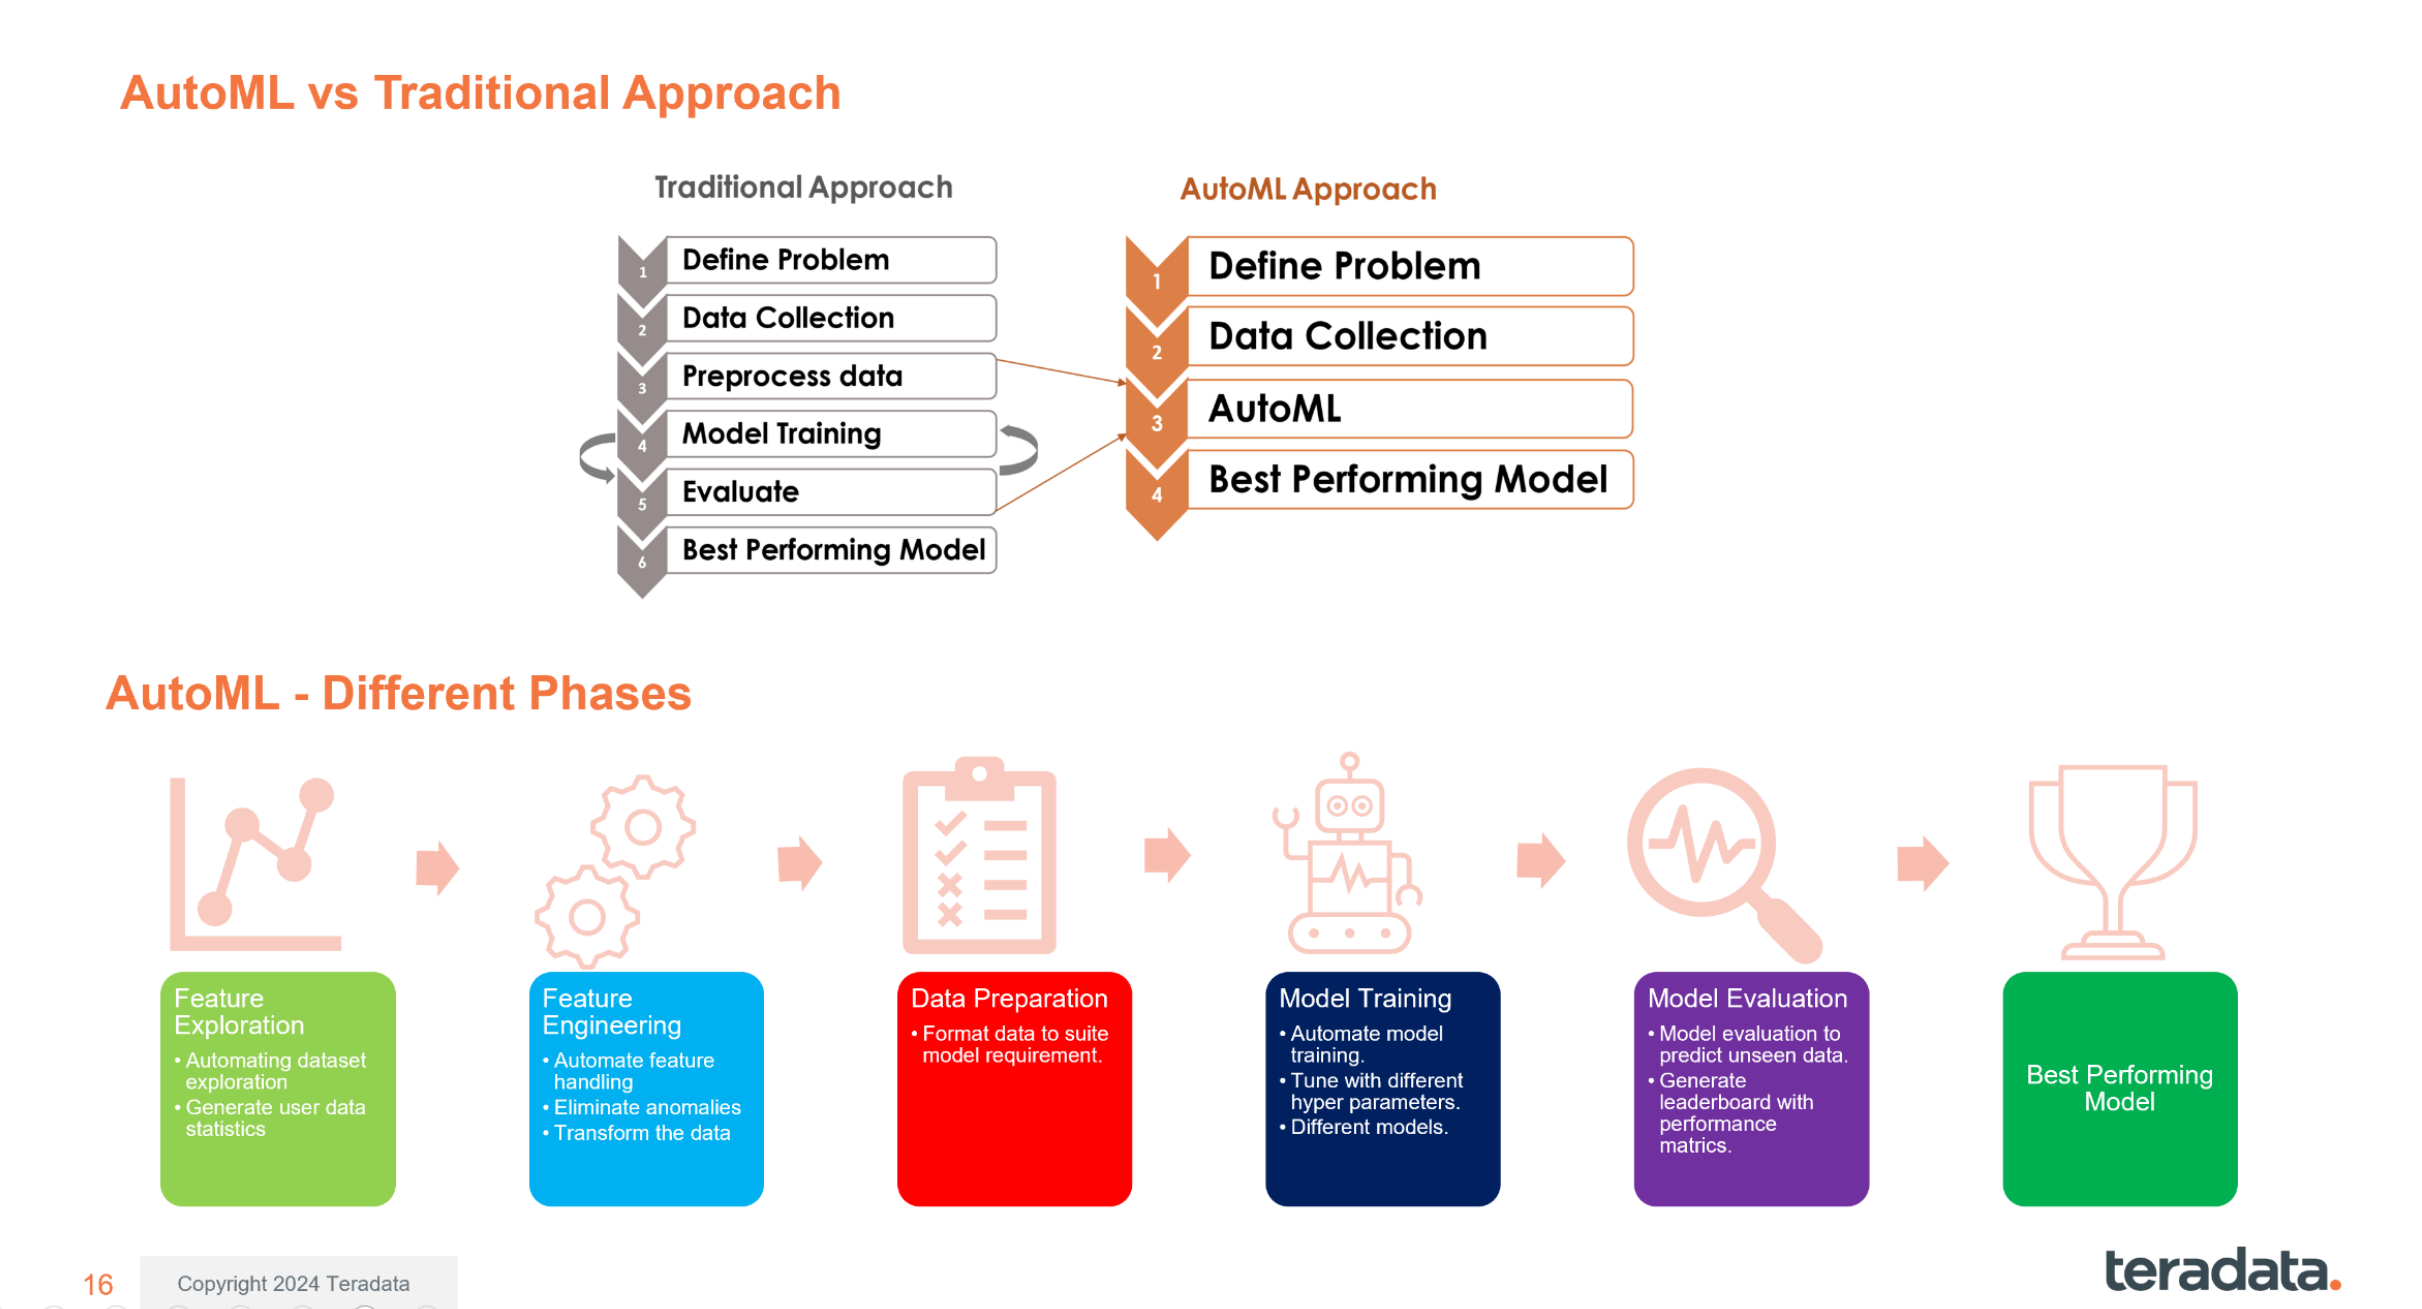

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Steps in the analysis:</b></p>
<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Connect to Vantage</li>
    <li>Data Exploration</li>
    <li>AutoML Training</li>
    <li>Model Leaderboard Generation</li>
    <li>Best Performing Model</li>
    <li>Prediction</li>
    <li>Cleanup</li>
</ol>

<hr style="height:1px;border:none;background-color:#00233C;">
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we import the required libraries, set environment variables and environment paths (if required).</p>

In [ ]:
import os
import getpass
from teradataml import *

# Modify the following to match the specific client environment settings
display.max_rows = 5
configure.val_install_location = 'val'
configure.byom_install_location = 'mldb'

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>1. Connect to Vantage</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We will be prompted to provide the password. We will enter the password, press the Enter key, and then use the down arrow to go to the next cell.</p>

In [ ]:
%run -i ../startup.ipynb
eng = create_context(host = 'host.docker.internal', username='demo_user', password = password)
print(eng)

In [ ]:
%%capture
execute_sql('''SET query_band='DEMO=BankingChurn.ipynb;' UPDATE FOR SESSION; ''')

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Begin running steps with Shift + Enter keys. </p>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage. We have the option of either running the demo using foreign tables to access the data without using any storage on our environment or downloading the data to local storage, which may yield somewhat faster execution. However, we need to consider available storage. There are two statements in the following cell, and one is commented out. We may switch which mode we choose by changing the comment string.</p>

In [ ]:
# %run -i ../run_procedure.py "call get_data('DEMO_BankChurn_cloud');"        # Takes 30 seconds
%run -i ../run_procedure.py "call get_data('DEMO_BankChurn_local');"        # Takes 1 minute

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – We should execute the below step only if we want to see the status of databases/tables created and space used.</p>

In [ ]:
%run -i ../run_procedure.py "call space_report();"        # Takes 10 seconds

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>2. Data Exploration</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We create a ‘Virtual DataFrame’ that references a data set in Vantage. Then, we check the dataframe’s shape and the data types of its columns.</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b><i>*Please scroll down to the end of the notebook for detailed column descriptions of the dataset.</i></b></p>

In [ ]:
tdf = DataFrame(in_schema("DEMO_BankChurn", "customer_churn"))
print("Shape of the data: ", tdf.shape)
tdf

In [ ]:
tdf.dtypes

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We drop the columns "RowNumber" and "Surname" as they are irrelevant to the outcome.</p>

In [ ]:
tdf = tdf.assign(Balance = tdf.Balance.cast(type_ = FLOAT()))
tdf = tdf.assign(EstimatedSalary = tdf.EstimatedSalary.cast(type_ = FLOAT()))
tdf = tdf.drop(['RowNumber', 'Surname'], axis = 1)

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We split the dataset in to training and testing dataset with 80:20 split ratio.</p>

In [ ]:
# Performing sampling to get 80% for trainning and 20% for testing
tdf_sample = tdf.sample(frac = [0.8, 0.2])

# Fetching train and test data
tdf_train= tdf_sample[tdf_sample['sampleid'] == 1].drop('sampleid', axis=1)
tdf_test = tdf_sample[tdf_sample['sampleid'] == 2].drop('sampleid', axis=1)

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>3. AutoML Training</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>AutoML (Automated Machine Learning) is an approach that automates the process of building, training, and validating machine learning models. It involves various algorithms to automate various aspects of the machine learning workflow, such as data preparation, feature engineering, model selection, hyperparameter tuning, and model deployment. It aims to simplify the process of building machine learning models, by automating some of the more time-consuming and labor-intensive tasks involved in the process.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We create a <code>AutoClassifier</code> instance which is a special purpose AutoML feature to run classification specific tasks. We use the <code>exclude</code> parameter to specify model algorithms to be excluded from model training phase. Here we exclude the 'knn' model. The <code>max_runtime_secs</code> specifies the time limit in seconds for model training.
<br><br>
<code>verbose</code>: specifies the detailed execution steps based on verbose level as follows:
</p>

<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li><b>0</b>: prints the progress bar and leaderboard</li>
    <li><b>1</b>: prints the execution steps of AutoML.</li>
    <li><b>2</b>: prints the intermediate data between the execution of each step of AutoML.</li>
</ul>

In [ ]:
'''
Creating AutoClassifier Instance
Selecting 'Auto' mode for AutoML training
Excluding knn and svm model from default model list for training
Used early stopping timer criteria with value 300 sec
'''

aml = AutoClassifier(
    exclude = 'knn',
    verbose = 2,
    max_runtime_secs = 300
)

In [ ]:
# Fitting train data 

aml.fit(tdf_train, 'Exited')

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>4. Model Leaderboard Generation</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we generate model leaderboard and leader for a given dataset. Leaderboard is a ranked table with a list of models with all their evaluation metrics.</p>

In [ ]:
# Fetching leaderboard

aml.leaderboard()

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>5. Best Performing Model</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following function displays the best performing model.</p>

In [ ]:
# Fetching best performing model
aml.leader()

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>6. Prediction</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The predict function generates predictions using either the default test data or any specified dataset, based on the model's rank in the leaderboard, and displays the performance metrics of the chosen model. If the test data contains a target column, both predictions and performance metrics are displayed; otherwise, only the predictions are shown.
<br><br>
You can also use the <code>rank</code> parameter in the predict function. The <code>rank</code> parameter specifies the model's rank in the leaderboard to be used for prediction. By default, the rank is set to 1, meaning the best-performing model is used.</p>

<hr style="height:1px;border:none;background-color:#00233C;">
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>6.1 Generating prediction on default validation test data</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In this instance, we are not specifying a test dataset when calling the predict function. As a result, the function will use the default test dataset for prediction. The default test dataset is the one generated during the training phase.</p>

In [ ]:
# Fetching prediction and metrics on default test data
prediction = aml.predict()

In [ ]:
# Printing prediction
prediction

<hr style="height:1px;border:none;background-color:#00233C;">
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>6.2 Generating prediction on external test data</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we specify the <code>tdf_test</code> dataset for prediction. When using external data instead of the default test data, the predict function applies all the data transformation steps performed during the training phase before passing the data to the model for prediction.</p>

In [ ]:
# Fetching prediction and metrics on test data
prediction = aml.predict(tdf_test)

In [ ]:
# Printing prediction
prediction

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>Conclusion</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Teradata's AutoML functionality plays a crucial role in this context by automating the complex process of building and deploying machine learning models. AutoML ensures the most optimal preparation and training of models, delivering high-quality machine learning models in minutes. Through hyperparameter tuning (HPT), Teradata's AutoML can automatically select the best parameters for machine learning algorithms using grid search and random search techniques, significantly enhancing model performance.
<br><br>
By leveraging Teradata's AutoML, banks can save time and reduce costs associated with manual model building and tuning. The technology not only improves the accuracy of predictive models but also democratizes the power of machine learning, allowing banks to utilize advanced analytics without requiring extensive coding or data science expertise. This capability enables banks to swiftly and effectively analyze customer churn data, develop predictive models, and implement proactive strategies to retain customers and enhance their satisfaction.
<br><br>
In conclusion, Teradata's AutoML functionality is a vital tool for banks aiming to reduce customer churn. By automating and optimizing the machine learning process, Teradata empowers banks to make data-driven decisions that improve customer retention and drive long-term profitability.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<b style = 'font-size:20px;font-family:Arial;color:#00233C'>7. Cleanup</b>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Databases and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

In [ ]:
%run -i ../run_procedure.py "call remove_data('DEMO_BankChurn');"        # Takes 10 seconds

In [ ]:
remove_context()

<hr style="height:1px;border:none;background-color:#00233C;">
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>Dataset:</b>

- `Surname`: Surname
- `CreditScore`: Credit score
- `Geography`: Country (Germany / France / Spain)
- `Gender`: Gender (Female / Male)
- `Age`: Age
- `Tenure`: No of years the customer has been associated with the bank
- `Balance`: Balance
- `NumOfProducts`: No of bank products used
- `HasCrCard`: Credit card status (0 = No, 1 = Yes)
- `IsActiveMember`: Active membership status (0 = No, 1 = Yes)
- `EstimatedSalary`: Estimated salary
- `Exited`: Abandoned or not? (0 = No, 1 = Yes)

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial'>
    <li>Teradataml Python reference: <a href = 'https://docs.teradata.com/search/all?query=Python+Package+User+Guide&content-lang=en-US'>here</a></li>
</ul>

<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2024. All Rights Reserved
        </div>
    </div>
</footer>